<a href="https://colab.research.google.com/github/Alimv81/emotion_detection_FER2012/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15257274744166538627
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17480240968477422970
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import cv2
import zipfile
import numpy as np
import pandas as pd
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers, losses, optimizers
from keras import callbacks

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
url = "https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
df_train = df[df['Usage']=='Training'].copy()
df_test = df[df['Usage']=='PublicTest'].copy()
df_valid = df[df['Usage']=='PrivateTest'].copy()

In [ ]:
num_classes = 7
input_shape = (48, 48, 3)

def split_data(data):
  data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  images = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
  images = np.repeat(images, 3, axis=-1) # to make the channels of the image into 3
  labels = data['emotion'].to_numpy()

  return images, labels

In [ ]:
train_data, train_labels = split_data(df_train)
test_data, test_labels = split_data(df_test)
validation_data, validation_labels = split_data(df_valid)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    fill_mode='nearest'
)

In [ ]:
model = Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
optimizer = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                      

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

In [ ]:
history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=64),
    epochs=35,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/35
449/449 [==============================] - 52s 81ms/step - loss: 1.8119 - accuracy: 0.2876 - val_loss: 18.5881 - val_accuracy: 0.0769 - lr: 0.0010
Epoch 2/35


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 35s 79ms/step - loss: 1.6060 - accuracy: 0.3710 - val_loss: 1.6089 - val_accuracy: 0.4266 - lr: 0.0010
Epoch 3/35
449/449 [==============================] - 41s 92ms/step - loss: 1.4436 - accuracy: 0.4428 - val_loss: 1.7367 - val_accuracy: 0.4492 - lr: 0.0010
Epoch 4/35
449/449 [==============================] - 34s 77ms/step - loss: 1.3530 - accuracy: 0.4852 - val_loss: 1.4657 - val_accuracy: 0.4536 - lr: 0.0010
Epoch 5/35
449/449 [==============================] - 37s 82ms/step - loss: 1.3151 - accuracy: 0.4958 - val_loss: 1.3867 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 6/35
449/449 [==============================] - 33s 74ms/step - loss: 1.2471 - accuracy: 0.5259 - val_loss: 1.2436 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 7/35
449/449 [==============================] - 35s 78ms/step - loss: 1.1985 - accuracy: 0.5441 - val_loss: 1.3238 - val_accuracy: 0.5355 - lr: 0.0010
Epoch 8/35
449/449 [==============================] - 33s 74ms/step -

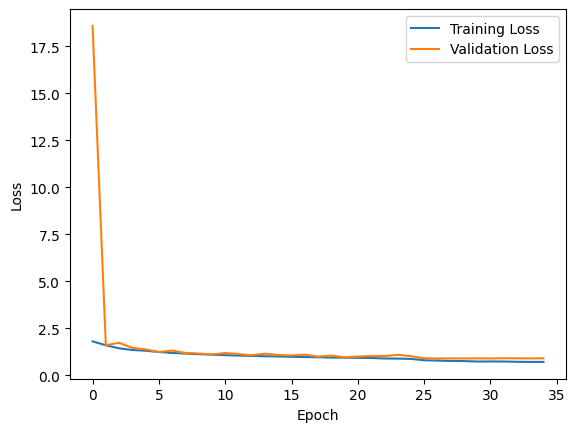

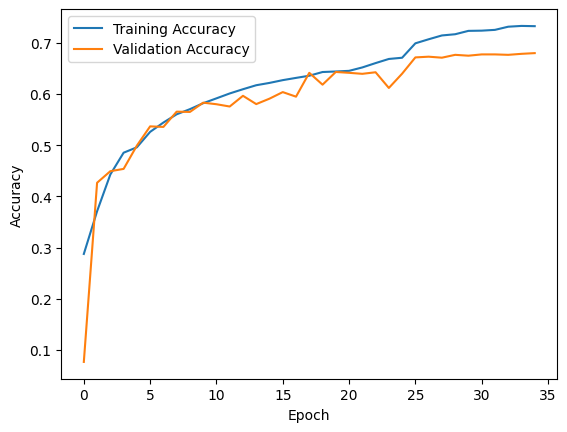

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
trlr_model = keras.Sequential()
base_model = keras.applications.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = True
trlr_model.add(base_model)
trlr_model.add(layers.Flatten())
trlr_model.add(layers.Dense(256, activation='relu'))
trlr_model.add(layers.Dense(num_classes, activation='softmax'))

optimizer = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()
trlr_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

history = trlr_model.fit(
    datagen.flow(train_data, train_labels, batch_size=64),
    epochs=20,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping, model_checkpoint]
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

115263384/115263384 [==============================] - 2s 0us/step
Epoch 1/20
151/449 [=========>....................] - ETA: 53s - loss: 1.8018 - accuracy: 0.2796

KeyboardInterrupt: ignored

In [ ]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
predy = model.predict(test_data)

In [ ]:
predy[0], np.argmax(predy[0])

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_labels, np.argmax(predy, axis=1)))

In [ ]:
idx = [96, 674, 1248, 2744]
image_batch = test_data[idx]
label_batch = test_labels[idx]
label_batch_pred = np.argmax(predy[idx], axis=1)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, ax in enumerate(axes):
    image = image_batch[i]
    ax.imshow(image)
    ax.set_title(f'true:{emotion_map[label_batch[i]]}, pred:{emotion_map[label_batch_pred[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/File.zip'

In [ ]:
with zipfile.ZipFile(path, 'r') as zip_ref:
  zip_ref.extractall('extracted/')

In [ ]:
images = []

files_names = os.listdir('extracted/')
for file_name in files_names:
  # image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_GRAYSCALE) # use this line if you want image channels number to be 1
  image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_COLOR) # use this line if you want image channels number to be 3

  image = cv2.resize(image, (48, 48))
  image = image.astype('float32') / 255.0
  # image = np.expand_dims(image, axis=-1) # use this line for one channeled images
  images.append(image)

In [ ]:
images = np.array(images)
y_hat = np.argmax(model.predict(images), axis=1)

In [ ]:
images.shape

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i in range(3):
  for j in range(4):
    ax = axes[i][j]
    if i!=2 or j!=3:
      ax.imshow(images[i*3 + j])
      ax.set_title(f'predicted: {emotion_map[y_hat[i*3 + j]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()